In [68]:
from sklearn.preprocessing import scale, LabelEncoder, StandardScaler, minmax_scale


import numpy as np
import pandas as pd
import librosa
from librosa import cqt
from librosa.feature import *
import librosa.display
import IPython.display as ipd
from PIL import Image

from datetime import datetime
import ffmpeg
import os
import string

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)


## Looking at the Sound Wave

In [17]:
audio_data = '../EDA/Jazz19.wav'
x , sr = librosa.load(audio_data, duration=10)

ipd.Audio(x, rate=sr)

(220500,) : [-0.01791382 -0.02279663 -0.02142334 ... -0.02987671 -0.02178955
 -0.01342773]


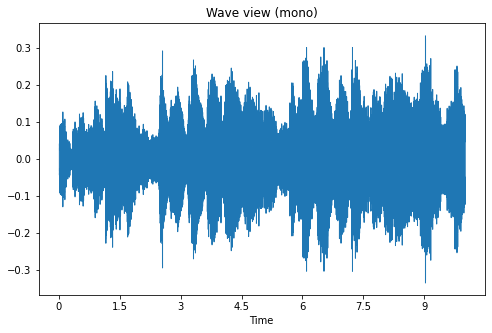

In [36]:
fig, ax = plt.subplots(figsize=(8,5))
librosa.display.waveshow(x, sr=sr, ax=ax)
ax.set(title='Wave view (mono)')
ax.label_outer()
fig.savefig('../EDA/wave.png');  
print(x.shape,':',x)

* The time series provided of audio cannot be understood by the models directly. Various transformations are performed to create useful features that can be analyzed by a model. 

## Generating a Spectogram

* Spectograms show different frequencies (y-axis) playing at a particular time (x-axis) along with it’s amplitude. 
* Amplitude and frequency are basic parameters that are valuable for audio classification

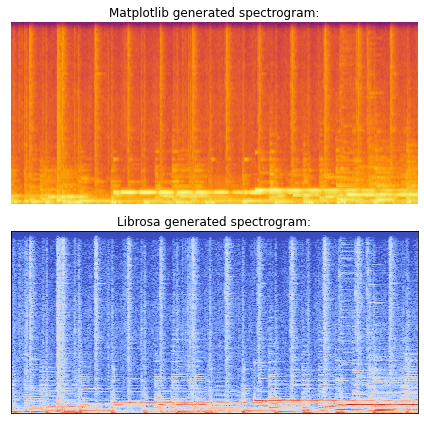

In [79]:
# using matplotlib:

fig, ax = plt.subplots(figsize=(6,6), nrows=2)

ax[0].set_title('Matplotlib generated spectrogram:')
ax[0].specgram(x, cmap='inferno');
ax[0].axis('off');

x_stft = librosa.stft(x)
ampl = librosa.amplitude_to_db(abs(x_stft))
librosa.display.specshow(ampl, ax=ax[1],)

ax[1].set_title('Librosa generated spectrogram:')
fig.tight_layout()
fig.savefig('../EDA/spectrograms.png');     

## Sample spectograms for different Genres:

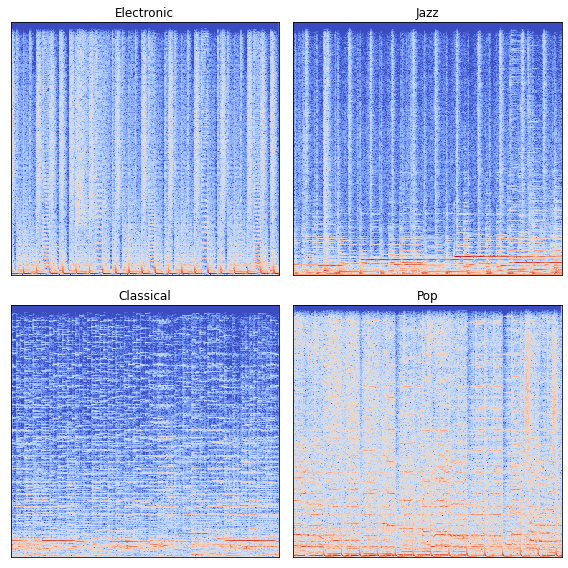

In [20]:
# will use Librosa:
fig, ax = plt.subplots(figsize=(8,8), nrows=2, ncols=2)

electronic = '../EDA/Electronic17.wav'
jazz = '../EDA/Jazz19.wav'
classical = '../EDA/Classical27.wav'
pop = '../EDA/Pop-7-1.wav'

x_electronic, sr = librosa.load(electronic,  duration=10)
x_jazz , sr = librosa.load(jazz,  duration=10)
x_classical , sr = librosa.load(classical,  duration=10)
x_pop, sr = librosa.load(pop,  duration=10)

ampl_electronic = librosa.amplitude_to_db(abs(librosa.stft(x_electronic)))
ampl_jazz = librosa.amplitude_to_db(abs(librosa.stft(x_jazz)))
ampl_classical = librosa.amplitude_to_db(abs(librosa.stft(x_classical)))
ampl_pop = librosa.amplitude_to_db(abs(librosa.stft(x_pop)))

librosa.display.specshow(ampl_electronic,ax=ax[0][0]);
librosa.display.specshow(ampl_jazz,ax=ax[0][1]);
librosa.display.specshow(ampl_classical,ax=ax[1][0]);
librosa.display.specshow(ampl_pop,ax=ax[1][1]);

ax[0][0].set_title('Electronic')
ax[0][1].set_title('Jazz')
ax[1][0].set_title('Classical')
ax[1][1].set_title('Pop')
fig.tight_layout()

fig.savefig('../EDA/spect_generes.png'); 

## Log transformed image

* As most of the action is happening at lower frequences log transformation is applied to see more details of lower frequencies registers

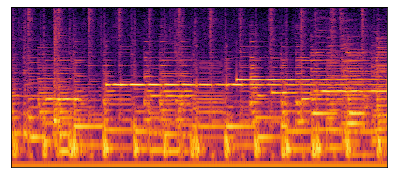

In [39]:
fig, ax = plt.subplots(figsize=(5,2))

x_stft = librosa.stft(x)
ampl = librosa.amplitude_to_db(abs(x_stft))
librosa.display.specshow(ampl, sr=20500, hop_length=512, x_axis='time',  y_axis='log',  ax=ax, cmap='inferno')

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

fig.tight_layout(pad=-1)
fig.savefig('../EDA/log_spectrograms2.png');   

# Features exploration:

## Mel-Frequency Cepstral Coefficients(MFCCs)

* Can be used to analyze timbre. Convert from hertz to mel scale and  by performing several transformations generate 8-20 coefficients that are used in music classication and speech recognision

(20, 431)


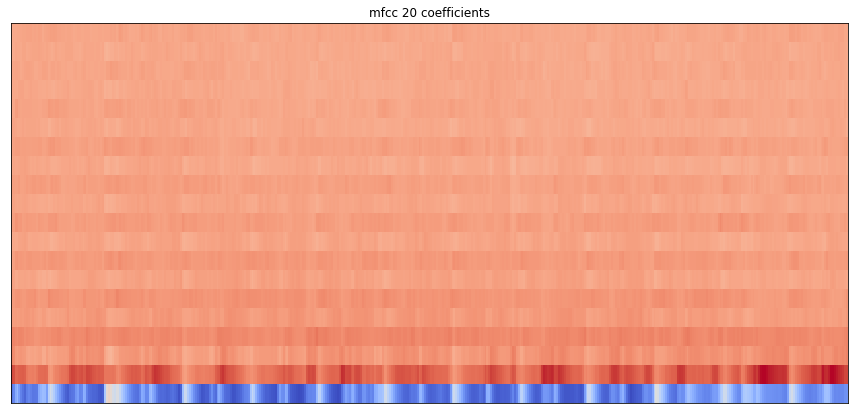

In [41]:
mfccs = librosa.feature.mfcc(S=ampl, sr=sr)  # n_mfcc default is 20
plt.figure(figsize=(15, 7))
plt.title('mfcc 20 coefficients')
librosa.display.specshow(mfccs, sr=sr);
print(mfccs.shape)
fig.savefig('../EDA/mfcc20.png'); 

### Zero-Crossing Rate

* is defined as the number of times the audio signal waveform crosses the zero amplitude level during a one second interval, which provides a rough estimator of the dominant frequency component of the signal. Higher percassive sounds will have a higher values than, for example a voice or a saxophone

Number of crossing in first 400 frames: 13


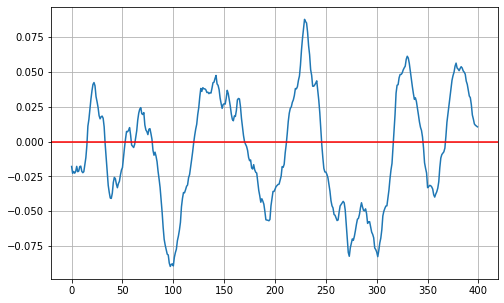

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
n0=0
n1=400
zero_crossings = librosa.zero_crossings(y=x[n0:n1], pad=False)

zero_crossings.shape
ax.plot(x[n0:n1])
ax.axhline(0, color='r')
ax.grid()
print(f'Number of crossing in first {n1} frames:',sum(zero_crossings))
fig.savefig('../EDA/zerocross.png'); 

## Chroma 

* Chroma is related to perception of pitch, complementing the tone height. In a musical context, the same note belonging to two different octaves would have the same chroma  and produce a similar effect on the human auditory perception

(12, 431)


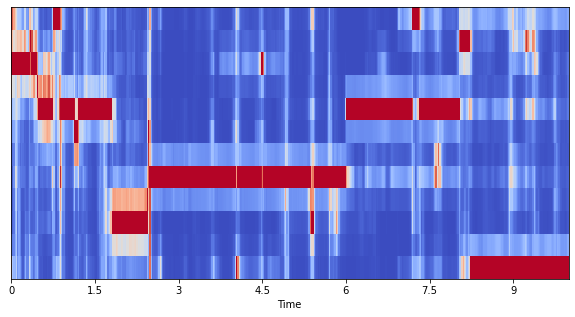

In [23]:
plt.figure(figsize=(10, 5))
chromagram = librosa.feature.chroma_stft(y=x)

librosa.display.specshow(chromagram, x_axis='time',  cmap='coolwarm');
fig.savefig('../EDA/chroma.png')
print(np.shape(chromagram));

## Spectral Rolloff

*  spectral rolloff point can be regarded as a measure of the skewness of the spectral shape. It can be used, for example, for distinguishing between voiced from unvoiced speech sounds.

(431,)

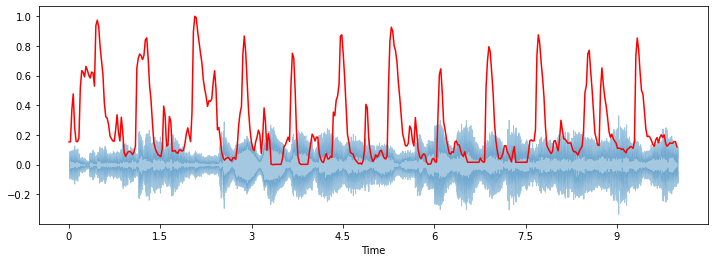

In [24]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr)[0]

plt.figure(figsize=(12, 4))

librosa.display.waveshow(y=x, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_rolloff, axis=0), color='r');
fig.savefig('../EDA/spectr_roloff.png'); 
np.shape(spectral_rolloff)

## Spectral Centroid
* , this feature describes the center of gravity of the spectral energy.

(431,)

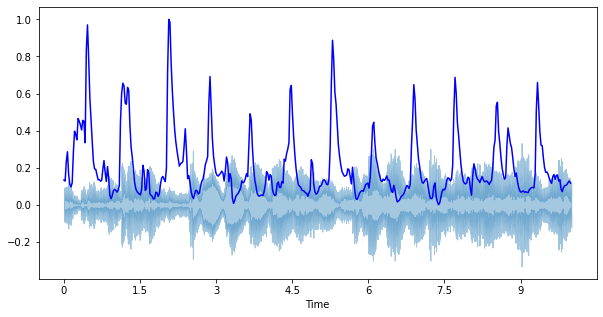

In [25]:
plt.figure(figsize=(10, 5))


spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_centroids, axis=0), color='b');

fig.savefig('../EDA/spectr_centr.png'); 
np.shape(spectral_centroids)

## Spectral Bandwidth

 * helps to discriminate tonal sounds (with low bandwidths) from noise-like sounds (with high bandwidths)


(431,)

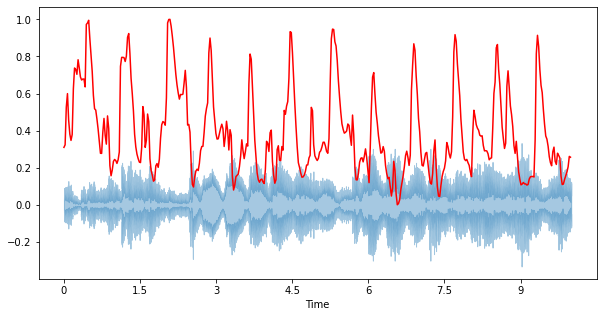

In [11]:
from sklearn.preprocessing import minmax_scale
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=x, sr=sr)[0]

plt.figure(figsize=(10, 5))

librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_bandwidth), color='r')
fig.savefig('../EDA/spectr_bandwidth.png'); 
np.shape(spectral_rolloff)


### RMS

The RMS measures the average loudness of an audio track. Its level is proportional to the amount of energy over a period of time in the signal.

(431,)

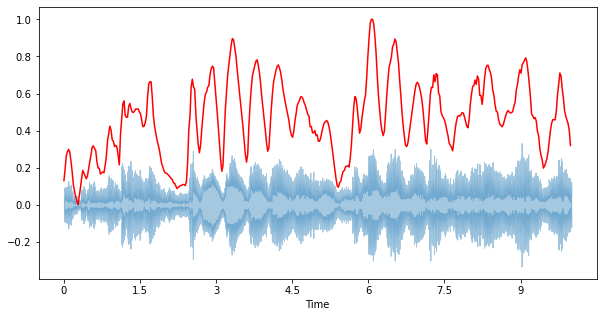

In [12]:
rmse = librosa.feature.rms(y=x)[0]

plt.figure(figsize=(10, 5))

librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(rmse), color='r')
fig.savefig('../EDA/rmse.png'); 
rmse.shape


### Spectral Contrast

* Spectral contrast is defined as the decibel difference between peaks and valleys in the spectrum.  

* Each frame of a spectrogram S is divided into sub-bands. For each sub-band, the energy contrast is estimated by comparing the mean energy in the top quantile (peak energy) to that of the bottom quantile (valley energy). High contrast values generally correspond to clear, narrow-band signals, while low contrast values correspond to broad-band noise.

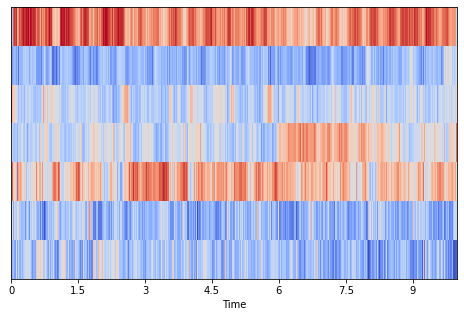

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
contrast2 = librosa.feature.spectral_contrast(y=x, sr=sr, )
librosa.display.specshow(scale(contrast2), sr=sr, x_axis='time',  ax=ax);
fig.savefig('../EDA/spect_contrast.png'); 

## Checking correlation for generated features

In [14]:
# orig_features_baseline.csv was created by extracting features above (plus rmse), 
df=pd.read_csv('../features/orig_features_baseline.csv')
df.head()

df.columns

Index(['filename', 'chroma_stft', 'rmse', 'spectral_centroid',
       'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2',
       'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10',
       'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17',
       'mfcc18', 'mfcc19', 'mfcc20', 'label'],
      dtype='object')

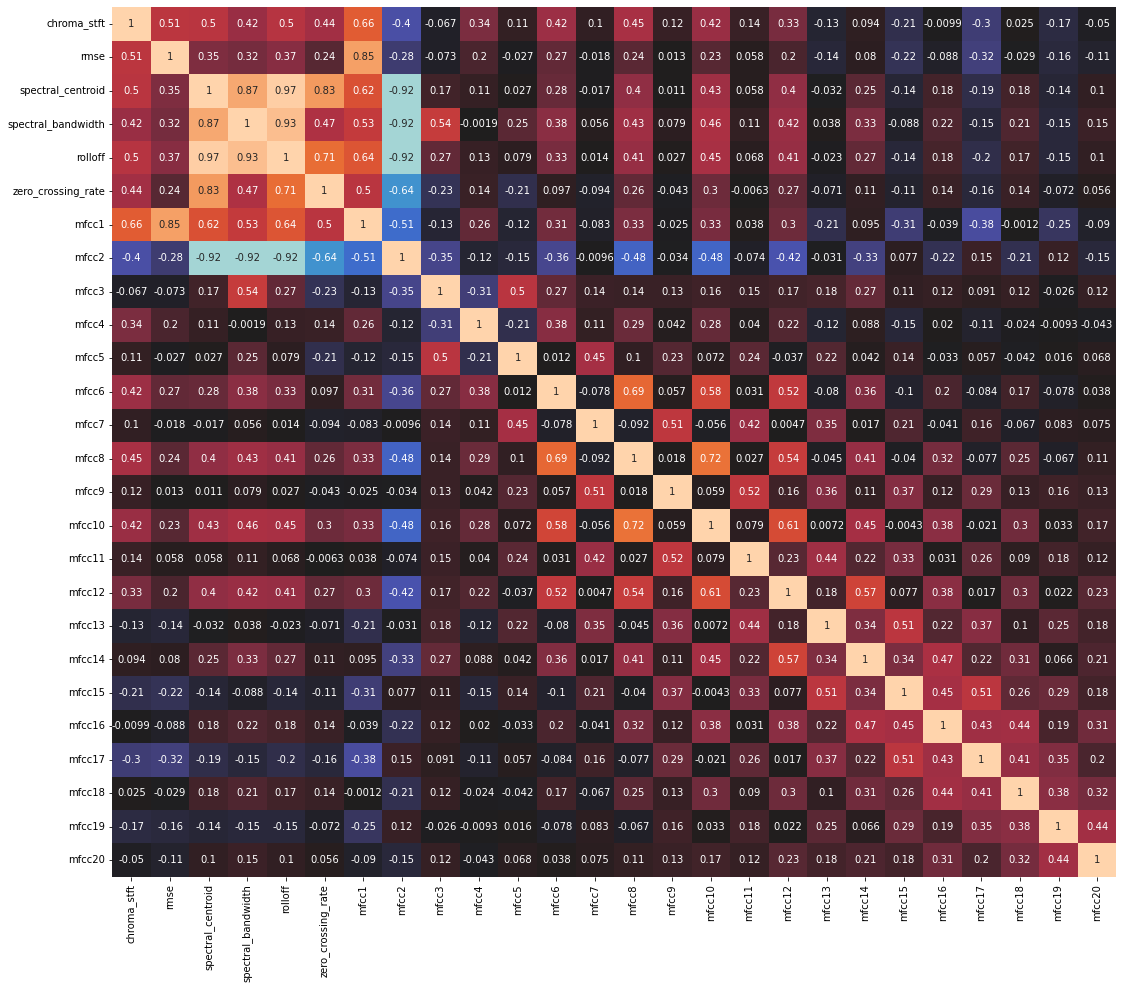

In [15]:
fig, ax = plt.subplots(figsize=(18,16))
import seaborn as sns

sns.heatmap(df.corr(), annot=True, center=0, ax=ax, cbar=False );

* #### Strong correlation between Spectral ~rolloff, ~centroid, and ~bandwidth

* Initially 7 characteristics were chosen for a baseline model: rmse, chroma_shft, central_centroid, central_rolloff, central_bandwidth, Zero Crossing Rate, and 20 mfcc channels. Also cqt and tonnets were considered.

After several iterations of testing the following was chosen:
* 13 mfcc channels, 7 spectral_contrasts channels,
* the means of: spectral_bandwidth, zero_crossing_rate, chroma_shft, and rmse for both harmonic and percussive wave split.

#### Example of separating sound in percussive and harmonic:

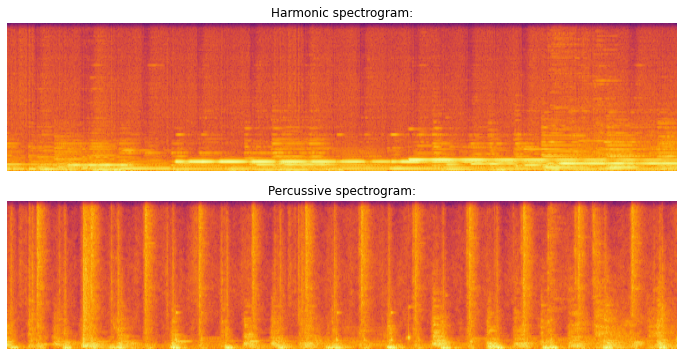

In [56]:
y_harm, y_perc = librosa.effects.hpss(x )

fig, ax = plt.subplots(figsize=(12,6), nrows=2)

ax[0].set_title('Harmonic spectrogram:')
ax[0].specgram(y_harm, cmap='inferno');
ax[0].axis('off');

ax[1].set_title('Percussive spectrogram:')
ax[1].specgram(y_perc, cmap='inferno');
ax[1].axis('off');

### Function to extract all the features:

In [57]:
def extract_features (x, sr):
    feat_dic={}
    x_harm, x_perc = librosa.effects.hpss(x)

# Power Based total Means
    for num, series in enumerate([x_harm, x_perc]):
        label={0:'harm',1:'perc'}
        for func in [rms, chroma_stft, spectral_bandwidth,  zero_crossing_rate]:
            feat_name=str(func).split()[1]
            if func == rms:
                s=librosa.stft(series)
                S, phase = librosa.magphase(s)
                feature = np.mean(func(S=S))
            else:
                feature = np.mean(func(y=series))
            feat_dic[f'{feat_name}_{label[num]}_mean']=feature

# Power Based Multiple Means
    for func in [ mfcc]:
        feat_lst = np.mean(func(y=x, sr=sr, n_mfcc=13), axis=1)

        feat_name=str(func).split()[1]

        for num, feature in enumerate(feat_lst):
            feat_dic[f'{feat_name}_{num}']=feature
# Energy Based:
    for func in [spectral_contrast ]:
        s=librosa.stft(x)
        feat_lst = np.mean(func(S=np.abs(s), sr=sr), axis=1)
        feat_name=str(func).split()[1]
        for num, feature in enumerate(feat_lst):
            feat_dic[f'{feat_name}_{num}']=feature
    return feat_dic


In [58]:
extract_features (x, sr)

{'rms_harm_mean': 0.03482193387917167,
 'chroma_stft_harm_mean': 0.17861192,
 'spectral_bandwidth_harm_mean': 1576.155455443979,
 'zero_crossing_rate_harm_mean': 0.04866158823955916,
 'rms_perc_mean': 0.009033926298947408,
 'chroma_stft_perc_mean': 0.52977353,
 'spectral_bandwidth_perc_mean': 2578.2698999870804,
 'zero_crossing_rate_perc_mean': 0.08924444424303944,
 'mfcc_0': -268.29956,
 'mfcc_1': 125.24438,
 'mfcc_2': 31.372765,
 'mfcc_3': 27.405245,
 'mfcc_4': 5.743326,
 'mfcc_5': 7.747109,
 'mfcc_6': -8.15932,
 'mfcc_7': 2.3627703,
 'mfcc_8': 1.4994603,
 'mfcc_9': 9.231843,
 'mfcc_10': 5.5647182,
 'mfcc_11': 7.812687,
 'mfcc_12': 0.8524211,
 'spectral_contrast_0': 16.224454706784144,
 'spectral_contrast_1': 15.473537460199532,
 'spectral_contrast_2': 25.842581985482944,
 'spectral_contrast_3': 21.19948377160586,
 'spectral_contrast_4': 18.869405378099472,
 'spectral_contrast_5': 15.24821182287195,
 'spectral_contrast_6': 29.849270390409252}

### Function to generate an image as used by CNN model:

In [73]:
def generate_image(x, image_chunk_name):
    fig, ax = plt.subplots(figsize=(3,3))

    x_stft = librosa.stft(x)
    ampl = librosa.amplitude_to_db(abs(x_stft))
    librosa.display.specshow(ampl, sr=20500, hop_length=512, x_axis='time',  y_axis='log',  ax=ax, cmap='inferno')

    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    fig.tight_layout(pad=-1)
    fig.savefig(image_chunk_name)
    fig.clear()
    plt.close(fig)



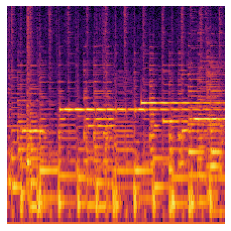

In [77]:
generate_image(x, 'test_spectrogram.png')
plt.imshow(Image.open('test_spectrogram.png'));
plt.axis('off');